In [40]:
import numpy as np
import pandas as pd
import mne
from matplotlib import pyplot as plt
import scipy.stats as sp_stats
import scipy.signal as sp_sig
import antropy as ant
from scipy.integrate import simps
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from ipynb.fs.defs.yasa_model import calc_features, get_metrics
import joblib
import math
from sklearn.preprocessing import robust_scale, normalize
from scipy import stats, signal

plt.style.use('dark_background')
pd.options.display.precision = 10

In [16]:
def format_raw_night(edf, channel):
    epochs = []
    window_size = int(sr / 4)
    if '-' in channel and 'REF' not in channel and 'E2' not in channel:
        chans = channel.split('-')
        raw = mne.io.read_raw_edf(edf).pick_channels(chans).resample(sr)
        # raw = remove_rem(raw, edf)
        mne.set_bipolar_reference(raw, chans[0], chans[1], ch_name=channel)
        raw_data = raw.get_data()[0]
    else:
        raw_data = mne.io.read_raw_edf(edf).pick_channels([channel]).resample(sr).get_data()[0]
    for i in range(0, len(raw_data), window_size):
        curr_block = raw_data[i: i  + window_size]
        if i + window_size < len(raw_data):
            epochs.append(curr_block)

    # Normalization
    epochs = np.array(epochs)
    epochs = (epochs - epochs.mean()) / epochs.std()
    return epochs

In [17]:
def bandpower_from_psd_ndarray(psd, freqs, bands, relative=True):
    # Type checks
    assert isinstance(bands, list), 'bands must be a list of tuple(s)'
    assert isinstance(relative, bool), 'relative must be a boolean'

    # Safety checks
    freqs = np.asarray(freqs)
    psd = np.asarray(psd)
    assert freqs.ndim == 1, 'freqs must be a 1-D array of shape (n_freqs,)'
    assert psd.shape[-1] == freqs.shape[-1], 'n_freqs must be last axis of psd'

    # Extract frequencies of interest
    all_freqs = np.hstack([[b[0], b[1]] for b in bands])
    fmin, fmax = min(all_freqs), max(all_freqs)
    idx_good_freq = np.logical_and(freqs >= fmin, freqs <= fmax)
    freqs = freqs[idx_good_freq]
    res = freqs[1] - freqs[0]

    # Trim PSD to frequencies of interest
    psd = psd[..., idx_good_freq]

    # Check if there are negative values in PSD
    if (psd < 0).any():
        msg = (
            "There are negative values in PSD. This will result in incorrect "
            "bandpower values. We highly recommend working with an "
            "all-positive PSD. For more details, please refer to: "
            "https://github.com/raphaelvallat/yasa/issues/29")
        print(msg)

    # Calculate total power
    total_power = simps(psd, dx=res, axis=-1)
    total_power = total_power[np.newaxis, ...]

    # Initialize empty array
    bp = np.zeros((len(bands), *psd.shape[:-1]), dtype=np.float)

    # Enumerate over the frequency bands
    labels = []
    for i, band in enumerate(bands):
        b0, b1, la = band
        labels.append(la)
        idx_band = np.logical_and(freqs >= b0, freqs <= b1)
        bp[i] = simps(psd[..., idx_band], dx=res, axis=-1)

    if relative:
        bp /= total_power
    return bp


def calc_features_fast(epochs, subj):
    # Bandpass filter
    freq_broad = (0.1, 500)
    # FFT & bandpower parameters
    sr = 1000
    bands = [
        (0.1, 4, 'delta'), (4, 8, 'theta'),
        (8, 12, 'alpha'), (12, 16, 'sigma'), (16, 30, 'beta'),
        (30, 100, 'gamma'), (100, 300, 'fast')
    ]

    # Calculate standard descriptive statistics
    hmob, hcomp = ant.hjorth_params(epochs, axis=1)

    feat = {
        'subj': np.full(len(epochs), subj),
        'epoch_id': np.arange(len(epochs)),
        'std': np.std(epochs, ddof=1, axis=1),
        'iqr': sp_stats.iqr(epochs, axis=1),
        'skew': sp_stats.skew(epochs, axis=1),
        'kurt': sp_stats.kurtosis(epochs, axis=1),
        'nzc': ant.num_zerocross(epochs, axis=1),
        'hmob': hmob,
        'hcomp': hcomp
    }

    # Calculate spectral power features (for EEG + EOG)
    freqs, psd = sp_sig.welch(epochs, sr)
    bp = bandpower_from_psd_ndarray(psd, freqs, bands=bands)
    for j, (_, _, b) in enumerate(bands):
        feat[b] = bp[j]

    feat['at'] = feat['alpha'] / feat['theta']
    feat['gt'] = feat['gamma'] / feat['theta']
    feat['ft'] = feat['fast'] / feat['theta']
    feat['ag'] = feat['gamma'] / feat['alpha']
    feat['af'] = feat['fast'] / feat['alpha']
    feat['sf'] = feat['sigma'] / feat['fast']
    feat['bf'] = feat['beta'] / feat['fast']
    feat['gf'] = feat['gamma'] / feat['fast']

    # Add total power
    idx_broad = np.logical_and(
        freqs >= freq_broad[0], freqs <= freq_broad[1])
    dx = freqs[1] - freqs[0]
    feat['abspow'] = np.trapz(psd[:, idx_broad], dx=dx)

    # Calculate entropy and fractal dimension features
    feat['perm'] = np.apply_along_axis(
        ant.perm_entropy, axis=1, arr=epochs, normalize=True)
    feat['higuchi'] = np.apply_along_axis(
        ant.higuchi_fd, axis=1, arr=epochs)
    feat['petrosian'] = ant.petrosian_fd(epochs, axis=1)

    # Convert to dataframe
    feat = pd.DataFrame(feat)
    # feat.index.name = 'epoch'

    #############################
    # SMOOTHING & NORMALIZATION
    #############################
    roll1 = feat.rolling(window=1, center=True, min_periods=1, win_type='triang').mean()
    roll1[roll1.columns] = robust_scale(roll1, quantile_range=(5, 95))
    roll1 = roll1.iloc[:, 2:].add_suffix('_cmin_norm')

    roll3 = feat.rolling(window=3, center=True, min_periods=1, win_type='triang').mean()
    roll3[roll3.columns] = robust_scale(roll3, quantile_range=(5, 95))
    roll3 = roll3.iloc[:, 2:].add_suffix('_pmin_norm')

    # Add to current set of features
    feat = feat.join(roll1).join(roll3)

    return feat

In [18]:
model = joblib.load('/Users/rotemfalach/Documents/University/lab/data/lgbm_AH_only_7.pkl')
features_names = pd.read_csv('/Users/rotemfalach/Documents/University/lab/data/features_AH_only_7.csv').columns.tolist()
edf_path = '/Users/rotemfalach/Documents/University/lab/data/%s_for_tag.edf'
sr = 1000

/Users/rotemfalach/projects/venv/mmf_to_edf/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator LabelEncoder from version 1.0.2 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [25]:
threshold_env = 8  # threshold in standard deviations for the envelope after bandpass (HP)
threshold_amp = 5  # threshold in standard deviations for the amplitude
threshold_grad = 5 # threshold in standard deviations for the gradient
threshold_env_conj = 3
threshold_amp_conj = 3
threshold_grad_conj = 3
use_env = True
use_amp = True
use_grad = True
use_amp_grad = True
use_amp_env = True
block_size_sec = 10  # filter and find peaks at blocks of X seconds - based on Andrillon et al

# the bandpass range is based on Andrillon et al
low_pass = 50
high_pass = 150

min_spike_length_ms = 5  # a spike is detected if there are points for X ms passing the threshold - in ms, based on Andrillon et al
common_spikes_index = []

# format: [spike_id, threshold_type, first_index, last_index, max_index, max_amp, duration(calc once for all after convert to df), sleep_stage?]
spikes_list = []


def get_markers(data, index_above_threshold, thresh_type, sr):
    max_markers_index = []
    max_marker_value = []
    min_spike_points = sr / (1000 / min_spike_length_ms)
    # find max markers
    counter = 1
    curr_spike = [thresh_type, index_above_threshold[0]]
    for j in range(len(index_above_threshold)):
        # check that the next index is the same spike
        if j + 1 < len(index_above_threshold) and index_above_threshold[j + 1] - index_above_threshold[j] == 1:
            counter += 1
        # the current spike finished
        else:
            # check min time of spike
            if counter >= min_spike_points:
                # check if the peak is positive or negative and append it's value
                max_value = data[index_above_threshold[j - counter + 1]: index_above_threshold[j] + 1].max()
                min_value = data[index_above_threshold[j - counter + 1]: index_above_threshold[j] + 1].min()
                value = max_value if abs(max_value) > abs(min_value) else min_value
                index = np.intersect1d(np.where(data == value)[0], index_above_threshold[j - counter + 1: j + 1])[0]
                max_marker_value.append(value)
                max_markers_index.append(index)
                curr_spike.extend((index_above_threshold[j], index, value))
                spikes_list.append(curr_spike)

            if j + 1 < len(index_above_threshold):
                curr_spike = [thresh_type, index_above_threshold[j + 1]]
                counter = 1

    return np.array(max_markers_index), np.array(max_marker_value)


def detect(data, sampling_rate, thresh_amp, thresh_grad, thresh_env, plot=False):
    points_in_block = block_size_sec * sampling_rate
    number_of_blocks = math.floor(len(data) / points_in_block)
    max_markers_index_amp, max_markers_index_grad, max_markers_index_env, all_common_index, all_common_value = [], [], [], [], []
    if plot:
        plt.plot(data, alpha=0.8)

    for i in range(number_of_blocks):
        curr_block = data[i * points_in_block: (i + 1) * points_in_block]

        # check amplitude threshold
        if use_amp or use_amp_env or use_amp_grad:
            z_score_amp = stats.zscore(curr_block)
            points_above_thresh_amp = z_score_amp[z_score_amp > thresh_amp]
            points_above_low_thresh_amp = z_score_amp[z_score_amp > threshold_amp_conj]
            # get indexes from z_score values and add offset of the current block
            if len(points_above_thresh_amp) > 0:
                index_above_threshold_amp = (z_score_amp > thresh_amp).nonzero()[0] + i * points_in_block
                max_markers_index_amp, max_marker_value_amp = get_markers(data, index_above_threshold_amp, 'amp', sampling_rate)

        # check gradient threshold
        if use_grad or use_amp_grad:
            gradient_diff = np.diff(curr_block)
            z_score_grad = stats.zscore(np.insert(gradient_diff, 0, 0))
            points_above_thresh_grad = z_score_grad[z_score_grad > thresh_grad]
            points_above_low_thresh_grad = z_score_grad[z_score_grad > threshold_grad_conj]
            if len(points_above_thresh_grad) > 0:
                index_above_threshold_grad = (z_score_grad > thresh_grad).nonzero()[0] + i * points_in_block
                max_markers_index_grad, max_marker_value_grad = get_markers(data, index_above_threshold_grad, 'grad', sampling_rate)

        # check envelope threshold
        if use_env or use_amp_env:
            filtered_block = mne.filter.filter_data(curr_block, sampling_rate, low_pass, high_pass)
            env_block = abs(signal.hilbert(filtered_block))
            z_score_env = stats.zscore(env_block)
            points_above_thresh_env = z_score_env[z_score_env > thresh_env]
            points_above_low_thresh_env = z_score_env[z_score_env > threshold_env_conj]
            if len(points_above_thresh_env) > 0:
                index_above_threshold_env = (z_score_env > thresh_env).nonzero()[0] + i * points_in_block
                max_markers_index_env, max_marker_value_env = get_markers(data, index_above_threshold_env, 'env', sampling_rate)

        # check conjunction of amplitude and gradient with lower thresholds
        if use_amp_grad:
            if len(points_above_low_thresh_amp) > 0 and len(points_above_low_thresh_grad) > 0:
                index_above_low_threshold_amp = (z_score_amp > threshold_amp_conj).nonzero()[0] + i * points_in_block
                index_above_low_threshold_grad = (z_score_grad > threshold_grad_conj).nonzero()[0] + i * points_in_block
                # get the common indexes of the two thresholds
                index_above_low_thresh_amp_grad = np.intersect1d(index_above_low_threshold_amp, index_above_low_threshold_grad)
                if len(index_above_low_thresh_amp_grad) > 0:
                    max_markers_index_amp_grad, max_marker_value_amp_grad = get_markers(data, index_above_low_thresh_amp_grad, 'amp_grad', sampling_rate)

        # check conjunction of amplitude and envelope with lower thresholds
        if use_amp_env:
            if len(points_above_low_thresh_amp) > 0 and len(points_above_low_thresh_env) > 0:
                index_above_low_threshold_amp = (z_score_amp > threshold_amp_conj).nonzero()[0] + i * points_in_block
                index_above_low_threshold_env = (z_score_env > threshold_env_conj).nonzero()[0] + i * points_in_block
                # get the common indexes of the two thresholds
                index_above_low_thresh_amp_env = np.intersect1d(index_above_low_threshold_amp, index_above_low_threshold_env)
                if len(index_above_low_thresh_amp_env) > 0:
                    max_markers_index_amp_grad, max_marker_value_amp_grad = get_markers(data, index_above_low_thresh_amp_env, 'amp_env', sampling_rate)

        # TODO: add the conjunctions!!
        if plot:
            # find the points that are shared in all thresholds
            common_index = np.intersect1d(max_markers_index_amp, max_markers_index_grad)
            if len(common_index) > 0:
                all_common_index = np.intersect1d(common_index, max_markers_index_env)
                common_spikes_index.extend(all_common_index)
                all_common_value = data[all_common_index] if len(all_common_index) > 0 else []

                # remove the shared points
                max_markers_index_amp = max_markers_index_amp[~np.in1d(max_markers_index_amp, all_common_index)]
                max_markers_index_grad = max_markers_index_grad[~np.in1d(max_markers_index_grad, all_common_index)]
                max_markers_index_env = max_markers_index_env[~np.in1d(max_markers_index_env, all_common_index)]

            # draw
            plt.scatter(all_common_index, all_common_value, marker='D', color='black')
            plt.scatter(max_markers_index_amp, data[max_markers_index_amp] if len(max_markers_index_amp) > 0 else [], marker='X', color='fuchsia')
            plt.scatter(max_markers_index_grad, data[max_markers_index_grad] if len(max_markers_index_grad) > 0 else [], marker='P', color='red')
            plt.scatter(max_markers_index_env, data[max_markers_index_env] if len(max_markers_index_env) > 0 else [], marker='o', color='blue', s=15)
            plt.legend(['signal', 'all', 'amplitude', 'gradient', 'envelope'], loc='upper right')
            # plt.scatter(max_markers_index_env, max_marker_value_env, marker='X', color='black')

    print('cool')
    if plot:
        plt.close()

    return True


In [20]:
channel = 'LAH1'
subj = '416'
x = format_raw_night(edf_path % subj, channel)
features = calc_features_fast(x, subj)
y = model.predict(features[features_names[1:]])

Extracting EDF parameters from /Users/rotemfalach/Documents/University/lab/data/416_for_tag.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/Users/rotemfalach/projects/venv/mmf_to_edf/lib/python3.7/site-packages/scipy/signal/spectral.py:1963: UserWarning: nperseg = 256 is greater than input length  = 250, using nperseg = 250
  .format(nperseg, input_length))


In [22]:
y.sum()

96.0

In [ ]:
from sklearn.metrics import confusion_matrix
def get_cm(raw, tags, detections, sr):
    # make it 1Hz
    y_actual = np.zeros(int(raw.n_times / sr), dtype=int)
    y_pred = np.zeros(int(raw.n_times / sr), dtype=int)
    # floor to 1 sec resolution
    for x in tags:
        y_actual[math.floor(x)] = 1
        # y_actual[int(x * 4) - 1: int(x * 4) + 2] = 1
    for i, x in detections[detections['max_index'] / sr < raw.n_times/ sr].iterrows():
        y_pred[math.floor(x['max_index'] / sr)] = 1

    cm = confusion_matrix(y_actual, y_pred)
    return cm, y_actual, y_pred

In [ ]:
# old code
path = 'C:\\Users\\user\\PycharmProjects\\pythonProject\\results\\'

results_dict = {'file': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'cm': [], 'tags_count': [], 'roc_auc': [],
                'avg_precision': []}
for subj in [34]:
    raw = mne.io.read_raw_edf(path + f'{subj}\\{subj}_for_tag.edf')
    right_tags = pd.read_csv(path + f'{subj}\\{subj}_tags.csv')['R'].dropna()
    left_tags = pd.read_csv(path + f'{subj}\\{subj}_tags.csv')['L'].dropna()
    # take only 1 area for now
    files = [x for x in os.listdir(path + f'{subj}\\detections') if 'LAH1' in x]
    for file in files:
        pred_df = pd.read_csv(path + f'{subj}\\detections\\' + file)
        if 'RA' in file:
            tags = right_tags
        else:
            tags = left_tags
        # crop raw object according to the last spike tag
        raw.crop(tmin=0, tmax=tags[tags.size -1] + 1)
        cm, y_actual, y_pred = get_cm(raw, tags, pred_df, int(raw.info['sfreq']))
        metrics = get_metrics(cm)
        results_dict['file'].append(file)
        results_dict['accuracy'].append(metrics['accuracy'])
        results_dict['precision'].append(metrics['precision'])
        results_dict['recall'].append(metrics['recall'])
        results_dict['f1'].append(metrics['f1'])
        results_dict['cm'].append(cm)
        results_dict['tags_count'].append(tags.size)
        results_dict['roc_auc'].append(roc_auc_score(y_actual, y_pred))
        results_dict['avg_precision'].append(average_precision_score(y_actual, y_pred))

results_df = pd.DataFrame(results_dict).sort_values('roc_auc', ascending=False)

In [50]:
def get_maya_y(edf, chan):
    epochs, epochs_zscore, epochs_random, epochs_index = [], [], [], []
    window_size = 250
    raw = mne.io.read_raw_edf(edf)
    pred = pd.read_csv(edf.replace('.edf', '') + f'_{chan}_maya_params.csv')
    pred_df = pd.DataFrame(pred)
    # pred_df['onset'] = pred_df['max_index'] / 1000
    spikes_df = pd.DataFrame(raw.annotations)
    end_onset = list(spikes_df[spikes_df['description'].str.contains('END')]['onset'])[0]
    spikes_df = spikes_df[spikes_df['description'].str.contains(channel[0] + 't')]
    spikes_df = spikes_df.drop_duplicates(subset=['onset'])
    complete_spikes_df = spikes_df[spikes_df['onset'] < end_onset]

    # from second tags round- complete data
    raw_data = raw.crop(tmax=end_onset).pick_channels([channel]).resample(sr).get_data()[0]
    # normalize raw!
    raw_data = sp_stats.zscore(raw_data)

    for i in range(0, len(raw_data), window_size):
        curr_block = raw_data[i: i  + window_size]
        if i + window_size < len(raw_data):
            epochs.append(curr_block)

    y_windows = np.zeros(len(epochs))
    for onset in pred_df['max_index']:
        if int(onset / window_size) < len(y_windows):
            y_windows[int(onset / window_size)] = 1

    return y_windows

In [34]:
def format_raw(edf, channel):
    epochs, epochs_zscore, epochs_random, epochs_index = [], [], [], []
    window_size = int(sr / 4)
    raw = mne.io.read_raw_edf(edf)
    spikes = raw.annotations
    spikes_df = pd.DataFrame(spikes)
    end_onset = list(spikes_df[spikes_df['description'].str.contains('END')]['onset'])[0]
    spikes_df = spikes_df[spikes_df['description'].str.contains(channel[0] + 't')]
    spikes_df = spikes_df.drop_duplicates(subset=['onset'])
    complete_spikes_df = spikes_df[spikes_df['onset'] < end_onset]

    # from second tags round- complete data
    raw_data = raw.crop(tmax=end_onset).pick_channels([channel]).resample(sr).get_data()[0]
    raw_data = sp_stats.zscore(raw_data)

    for i in range(0, len(raw_data), window_size):
        curr_block = raw_data[i: i  + window_size]
        if i + window_size < len(raw_data):
            epochs.append(curr_block)

    y_windows = np.zeros(len(epochs))
    for onset in complete_spikes_df['onset']:
        y_windows[int(onset * 1000 / window_size)] = 1

    return y_windows

In [35]:
y_left = format_raw(edf, 'LAH1')

Extracting EDF parameters from /Users/rotemfalach/Documents/University/lab/Lilach_new/396_for_tag_filtered_fix_tag.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [38]:
y_left.sum()

17.0

In [39]:
y_maya_left.sum()

15.0

In [ ]:
get_metrics()

In [52]:
def plot_cm(y_test, y_pred):
    f, axes = plt.subplots(1, 1, figsize=(10, 5), sharey='row')
    cf_matrix = confusion_matrix(y_test, y_pred)
    metrics = get_metrics(cf_matrix)
    disp = ConfusionMatrixDisplay(cf_matrix)
    disp.plot(ax=axes)
    text = """precision: {0}
                  recall: {1}""".format(str('{0:.2f}'.format(metrics['precision'])), str('{0:.2f}'.format(metrics['recall'])))
    axes.annotate(text, xy=(1, 0), xycoords='axes fraction', fontsize=16,
                     xytext=(-60, -40), textcoords='offset points',
                     ha='right', va='top')
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i!=0:
        disp.ax_.set_ylabel('')

    f.text(0.5, 0.1, 'Predicted label', ha='left')
    plt.show()

Extracting EDF parameters from /Users/rotemfalach/Documents/University/lab/Lilach_new/416_for_tag_filtered_fix_tag.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /Users/rotemfalach/Documents/University/lab/Lilach_new/416_for_tag_filtered_fix_tag.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /Users/rotemfalach/Documents/University/lab/Lilach_new/416_for_tag_filtered_fix_tag.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /Users/rotemfalach/Documents/University/lab/Lilach_new/416_for_tag_filtered_fix_tag.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


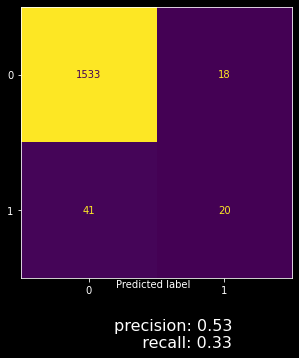

In [71]:
edf = '/Users/rotemfalach/Documents/University/lab/Lilach_new/416_for_tag_filtered_fix_tag.edf'
y_maya_right = get_maya_y(edf, 'RAH1-RAH2')
y_maya_left = get_maya_y(edf, 'LAH1-LAH2')
y_maya = np.concatenate((y_maya_right, y_maya_right))
y_right = format_raw(edf, 'RAH1-RAH2')
y_left = format_raw(edf, 'LAH1-LAH2')
y_bi = np.concatenate((y_right, y_left))
plot_cm(y_bi, y_maya)

Extracting EDF parameters from /Users/rotemfalach/Documents/University/lab/Lilach_new/416_for_tag_filtered_fix_tag.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /Users/rotemfalach/Documents/University/lab/Lilach_new/416_for_tag_filtered_fix_tag.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /Users/rotemfalach/Documents/University/lab/Lilach_new/416_for_tag_filtered_fix_tag.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /Users/rotemfalach/Documents/University/lab/Lilach_new/416_for_tag_filtered_fix_tag.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


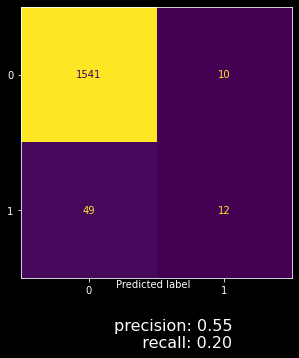

In [72]:
edf = '/Users/rotemfalach/Documents/University/lab/Lilach_new/416_for_tag_filtered_fix_tag.edf'
y_maya_right = get_maya_y(edf, 'RAH1')
y_maya_left = get_maya_y(edf, 'LAH1')
y_maya = np.concatenate((y_maya_right, y_maya_right))
y_right = format_raw(edf, 'RAH1')
y_left = format_raw(edf, 'LAH1')
y_bi = np.concatenate((y_right, y_left))
plot_cm(y_bi, y_maya)

In [62]:
y_maya

array([0., 0., 2., 0., 0., 2., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.